In [6]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
%pip install 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 23.0 MB/s eta 0:00:00m eta 0:00:010:0101
Note: you may need to restart the kernel to use updated packages.


Обнаружен файл: /home/user/projects/co_hack_fires/train/20/2021-05-15.tiff
Number of bands: 5


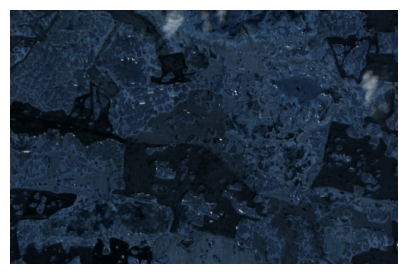

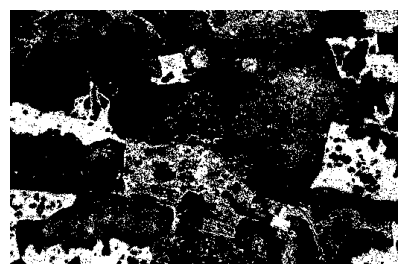

In [51]:
import os
import re
import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt

def find_tiff_file(directory):
    """Находит первый .tiff файл в указанной директории с помощью регулярного выражения"""
    tiff_pattern = re.compile(r'.*\.tiff$')  # Регулярное выражение для поиска .tiff файлов
    for file_name in os.listdir(directory):
        if tiff_pattern.match(file_name):
            return os.path.join(directory, file_name)
    raise FileNotFoundError("TIFF файл не найден в указанной директории")

def normalize_band(band):
    """Нормализует данные канала в диапазоне 0-255"""
    band_min, band_max = band.min(), band.max()
    normalized_band = (band - band_min) / (band_max - band_min) * 255.0
    return normalized_band.astype(np.uint8)

def visualize_rgb_geotiff(directory, r_band, g_band, b_band, ik_band, mask_band):
    try:
        # Поиск .tiff файла в указанной папке
        file_path = find_tiff_file(directory)
        print(f"Обнаружен файл: {file_path}")

        with rasterio.open(file_path) as src:
            num_bands = src.count
            print(f"Number of bands: {num_bands}")
            red = src.read(r_band)
            green = src.read(g_band)
            blue = src.read(b_band)
            ik = src.read(ik_band)
            mask = src.read(mask_band)

            # Нормализация каждого канала
            red_norm = normalize_band(red)
            green_norm = normalize_band(green)
            blue_norm = normalize_band(blue)

            photo_rgb = np.stack([red_norm, green_norm, blue_norm], axis=-1).astype(np.uint8)

            mask_stacked = np.stack([mask], axis=-1).astype(np.uint8) * 255

            base_name = os.path.splitext(os.path.basename(file_path))[0]  # Имя файла без расширения
            output_dir = os.path.dirname(file_path)  # Получаем директорию исходного файла
            
            filename = os.path.join(output_dir, f"{base_name}_photo_rgb.jpg")
            filename_mask = os.path.join(output_dir, f"{base_name}_mask.jpg")

            # Сохранение файлов
            cv2.imwrite(filename, photo_rgb)
            cv2.imwrite(filename_mask, mask_stacked)

            # Визуализация изображений
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(photo_rgb)
            ax.axis('off')
            plt.show()

            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(mask_stacked, cmap='gray')
            ax.axis('off')
            plt.show()

    except FileNotFoundError as fnf_error:
        print(fnf_error)
    except Exception as e:
        print(f'Ошибка: {e}')

directory = '/home/user/projects/co_hack_fires/train/20/'
visualize_rgb_geotiff(directory, 1, 2, 3, 4, 5)


In [54]:
%pip install segmentation_models.pytorch 

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=3d64d207d790dea2c31a25504a44de5d41162ff83b3d43f9ea8706962edeec87
  Stored in directory: /home/user/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=0b8c266e05687edcfa179f5f4687a3de11fec01220ce6ba87f6fa044de47e59a
  Stored in directory: /home/user/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels
Note: you may need to restart the kernel to use updated packages.


In [57]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset

In [70]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform_image=None, transform_mask=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])  # имена изображений и масок должны совпадать
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Маска - одноканальное изображение

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask


In [73]:
resize = transforms.Resize((256, 256))

In [74]:
transform_image = transforms.Compose([
    resize,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [75]:
transform_mask = transforms.Compose([
    resize,
    transforms.ToTensor()
])

In [81]:
dataset = SegmentationDataset(
    images_dir='/home/user/projects/co_hack_fires/train/full/train/images/',
    masks_dir='/home/user/projects/co_hack_fires/train/full/train/masks/',
    transform_image=transform_image,
    transform_mask=transform_mask
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [103]:
model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=1)

In [104]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [105]:
def pixel_accuracy(outputs, masks):
    outputs = (outputs > 0.5).float()
    correct = (outputs == masks).float().sum()
    total = torch.numel(masks)
    return correct / total

In [106]:
def calculate_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()

    intersection = torch.sum((pred * target))

    union = torch.sum(pred) + torch.sum(target) - intersection
    
    if union == 0:
        return torch.tensor(1.0)
        
    iou = intersection / union
    return iou


In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    iou_score = 0.0
    pixel_acc = 0.0
    
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        batch_iou = 0.0
        for i in range(images.size(0)):  # Проходим по каждому изображению в батче
            iou = calculate_iou(outputs[i], masks[i])
            batch_iou += iou.item()
        
        iou_score += batch_iou / images.size(0)

        # Pixel accuracy
        pixel_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_iou = iou_score / len(dataloader)  # IoU на батчах
    epoch_pixel_acc = pixel_acc / len(dataloader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, IoU: {epoch_iou:.4f}, Pixel Accuracy: {epoch_pixel_acc:.4f}")


Epoch 1/100, Loss: 0.4534, IoU: 0.1171, Pixel Accuracy: 0.7137
Epoch 2/100, Loss: 0.4336, IoU: 0.1551, Pixel Accuracy: 0.7170
Epoch 3/100, Loss: 0.4170, IoU: 0.1240, Pixel Accuracy: 0.7161
Epoch 4/100, Loss: 0.4105, IoU: 0.1310, Pixel Accuracy: 0.7172
Epoch 5/100, Loss: 0.4172, IoU: 0.1502, Pixel Accuracy: 0.7185
Epoch 6/100, Loss: 0.4002, IoU: 0.1598, Pixel Accuracy: 0.7175
Epoch 7/100, Loss: 0.4093, IoU: 0.1780, Pixel Accuracy: 0.7219
Epoch 8/100, Loss: 0.3867, IoU: 0.1545, Pixel Accuracy: 0.7203
Epoch 9/100, Loss: 0.3938, IoU: 0.1634, Pixel Accuracy: 0.7179
Epoch 10/100, Loss: 0.3658, IoU: 0.1681, Pixel Accuracy: 0.7223
Epoch 11/100, Loss: 0.3674, IoU: 0.1654, Pixel Accuracy: 0.7207
Epoch 12/100, Loss: 0.3661, IoU: 0.1575, Pixel Accuracy: 0.7190
Epoch 13/100, Loss: 0.3480, IoU: 0.1841, Pixel Accuracy: 0.7242
Epoch 14/100, Loss: 0.3484, IoU: 0.1704, Pixel Accuracy: 0.7249
Epoch 15/100, Loss: 0.3477, IoU: 0.1621, Pixel Accuracy: 0.7235
Epoch 16/100, Loss: 0.3477, IoU: 0.1441, Pixel Ac